# Performance

How small do my tasks need to be (aka how fast is IPython)?

In parallel computing, an important relationship to keep in mind is the
ratio of computation to communication. In order for your simulation to
perform reasonably, you must keep this ratio high. When testing out a
new tool like IPython, it is important to examine the limit of
granularity that is appropriate. If it takes half a second of overhead
to run each task, then breaking your work up into millisecond chunks
isn't going to make sense.

Basic imports to use later, create a Client, and a LoadBalancedView of all the engines.

In [1]:
import time
import numpy as np

from IPython.core.display import Image

from ipyparallel import Client

rc = Client()
view = rc.load_balanced_view()

## Latency

Sending and receiving tiny messages gives us a sense of the minimum time
IPython must spend building and sending messages around. This should
give us a sense of the *minimum* overhead of the communication system.

This should give us a sense of the lower limit on available granularity.

In [2]:
def test_latency(v, n):
    tic = time.time()
    echo = lambda x: x
    tic = time.time()
    for i in range(n):
        v.apply_async(echo, '')
    toc = time.time()
    v.wait()
    tac = time.time()
    sent = toc-tic
    roundtrip = tac-tic
    return sent, roundtrip

In [3]:
for n in [8,16,32,64,128,256,512,1024]:
    # short rest between tests
    time.sleep(0.5)
    s,rt = test_latency(view, n)
    print("%4i %6.1f %6.1f" % (n,n/s,n/rt))

   8  110.1   66.8
  16 1271.1   97.8
  32  946.6  117.1
  64  899.2  125.6
 128  952.1  120.7
 256  750.7  128.8
 512  483.4  107.8
1024  481.4  124.1


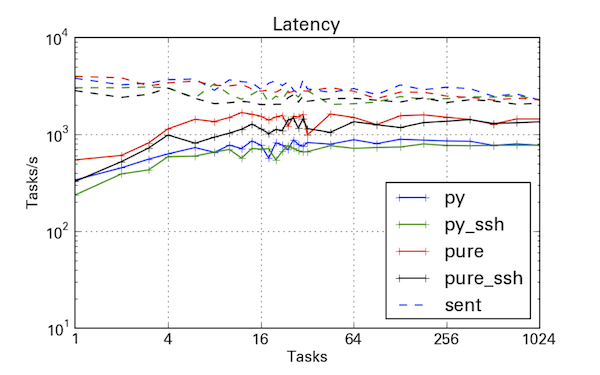

In [4]:
Image(filename="figs/latency.png")

These tests were run on the loopback interface on a fast 8-core machine
with 4 engines and slightly tuned non-default config (msgpack for serialization, TaskScheduler.HWM=0).

The tests were done with the Python scheduler and pure-zmq scheduler,
and with/without an SSH tunnel. We can see that the Python scheduler can
do about 800 tasks/sec, while the pure-zmq scheduler gets an extra
factor of two, at around 1.5k tasks/sec roundtrip. Purely outgoing - the
time before the Client code can go on working, is closer to 4k msgs/sec
sent. Using an SSH tunnel does not significantly impact performance, as
long as you have a few tasks to line up.

Running the same test on a dedicated cluster with up to 128 CPUs shows
that IPython does scale reasonably well.

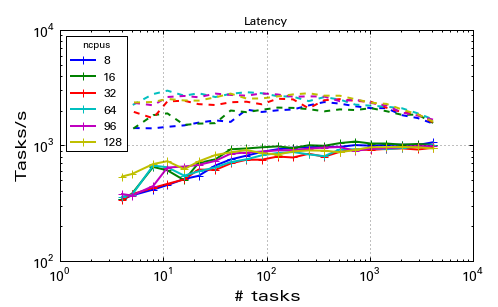

In [5]:
Image(filename="figs/latency2.png")

## Throughput

Echoing numpy arrays is similar to the latency test, but scaling the
array size instead of the number of messages tests the limits when there
is data to be transferred.

In [9]:
def test_throughput(v, n, s):
    A = np.random.random(int(s/8)) # doubles are 8Bit
    tic = time.time()
    echo = lambda x: x
    tic = time.time()
    for i in range(n):
        v.apply_async(echo, A)
    toc = time.time()
    v.wait()
    tac = time.time()
    sent = toc-tic
    roundtrip = tac-tic
    return sent, roundtrip

In [10]:
n = 128
for sz in [1e1,1e2,1e3,1e4,1e5,5e5,1e6]:
    # short rest between tests
    time.sleep(1)
    s,rt = test_throughput(view, n, int(sz))
    print("%8i  %6.1f  %6.1f" % (sz,n/s,n/rt))

      10   987.7   130.8
     100   356.7   114.4
    1000   982.1   145.9
   10000  1224.3   137.0
  100000  1266.8   142.0
  500000   555.3   118.0
 1000000  1028.2    93.7


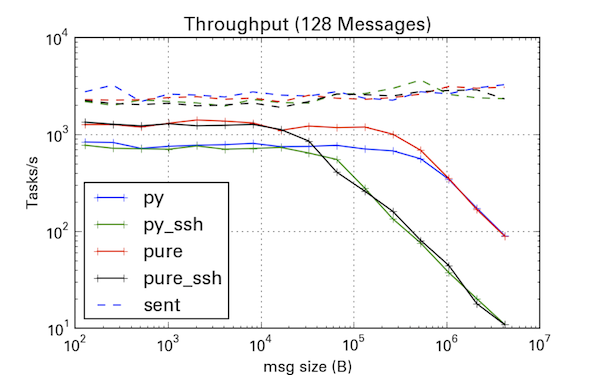

In [11]:
Image(filename="figs/throughput1.png")


Note that the dotted lines, which measure the time it took to *send* the
arrays is *not* a function of the message size. This is again thanks to
pyzmq's non-copying sends. Locally, we can send 100 4MB arrays in ~50
ms, and libzmq will take care of actually transmitting the data while we
can go on working.

Plotting the same data, scaled by message size shows that we are
saturating the connection at ~1Gbps with ~10kB messages when using
SSH, and ~10Gbps with ~50kB messages when not using SSH.

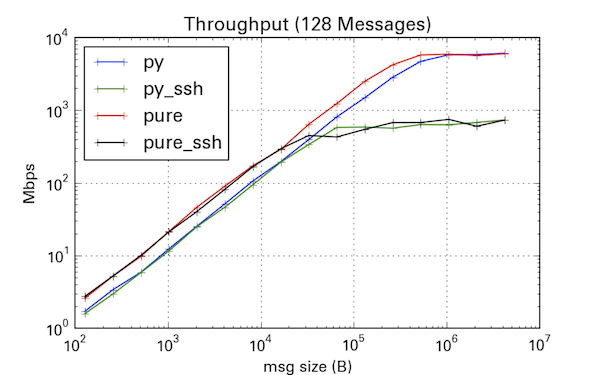

In [12]:
Image(filename="figs/throughput2.png")

## Map

Another useful test is seeing how fast \`view.map\` is, for various
numbers of tasks and for tasks of varying size.

These tests were done on [AWS](http://aws.amazon.com/) extra-large
instances with the help of
[StarCluster](http://web.mit.edu/stardev/cluster/), so the IO and CPU
performance are quite low compared to a physical cluster.

In [13]:
def test_map(v,dt,n):
    ts = [dt]*n
    tic = time.time()
    amr = v.map_async(time.sleep, ts)
    toc = time.time()
    amr.get()
    tac = time.time()
    sent = toc-tic
    roundtrip = tac-tic
    return sent, roundtrip

In [14]:
n = len(rc.ids) * 16
for dt in np.logspace(-3,0,7):
    time.sleep(0.5)
    s,rt = test_map(view, dt, n)
    print("%4ims %5.1f%%" % (1000*dt, 1600*dt / rt))

   1ms   3.0%
   3ms   9.6%
  10ms  31.1%
  31ms  49.6%
 100ms  82.8%
 316ms  93.4%
1000ms  97.6%


<img src="files/figs/map.png">

This shows runs for jobs ranging from 1 to 128 ms, on 4,31,and 63
engines. On this system, millisecond jobs are clearly too small, but by
the time individual tasks are \> 100 ms, IPython overhead is negligible.